<a href="https://colab.research.google.com/github/4d5645/StatsForDataAnalysis_MIPT/blob/main/Analysis_of_AB_test_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of AB test results
- analyzing an AB test conducted on real Yandex users

- confirming or denying the presence of changes in user behavior between the control (control) and test (exp) groups

- determining the nature of these changes and the practical significance of the introduced change

- understanding which of the user groups loses/benefits the most from the change being tested (localize the change)

In [54]:
%pylab inline
import pandas as pd
import numpy as np
import scipy
import math
import statsmodels
from scipy import stats
import matplotlib.pyplot as plt
import warnings
from itertools import product
from statsmodels.sandbox.stats.multicomp import multipletests
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [55]:
from google.colab import drive
drive.mount('/content/gdrive')
data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/MIPT/ab_browser_test.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Data Description:

- userID: unique user ID

- browser: the browser that used the userID

- slot: in what status the user participated in the study (exp = saw the modified page, control = saw the unchanged page)

- n_clicks: number of clicks the user made in n_queries

- n_queries: number of queries that userID made using the browser browser

- n_nonclk_queries: number of user requests in which they did not make a single click


In [73]:
data

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30
...,...,...,...,...,...,...
566129,603133,Browser #14,control,1,2,1
566130,603134,Browser #2,exp,4,2,0
566131,603135,Browser #4,control,0,1,1
566132,603136,Browser #4,control,2,3,1


In [57]:
exp = data[data.slot == 'exp']
control = data[data.slot == 'control']

In [58]:
exp_click = exp.n_clicks.sum()
print(f'Amount of clicks in exp group: {exp_click}')
control_click = control.n_clicks.sum()
print(f'Amount of clicks in control group: {control_click}')
goal = exp_click / control_click * 100 - 100
print(f'Difference in %: {goal}')

Amount of clicks in exp group: 3261823
Amount of clicks in control group: 3210027
Difference in %: 1.6135689824415778


Let's try to take a closer look at the difference between the two groups (control and exp) regarding the number of user clicks.

To do this, we will use the bootstrap to construct a 95% confidence interval for the averages and medians of the number of clicks in each of the two groups.

In [59]:
# bootstrap estimate of the medians
def get_bootstrap_samples(data, n_samples):
  indices = np.random.randint(0, len(data), (n_samples, len(data)))
  samples = data[indices]
  return samples

def stat_intervals(stat, alpha):
  boundaries = np.percentile(stat, [100 * alpha / 2., 100 *(1 - alpha / 2.)])
  return boundaries

np.random.seed(0)
exp_median_scores = np.array(list(map(np.median, get_bootstrap_samples(exp.n_clicks.to_numpy(), 1000))))
control_median_scores = np.array(list(map(np.median, get_bootstrap_samples(control.n_clicks.to_numpy(), 1000))))
print('95% confidence interval for median exp', stat_intervals(exp_median_scores, 0.05))
print('95% confidence interval for median control', stat_intervals(control_median_scores, 0.05))

delta_median_scores = np.array(list(map(lambda x: x[0] - x[1], zip(exp_median_scores, control_median_scores))))
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for median exp [5. 5.]
95% confidence interval for median control [4. 4.]
95% confidence interval for the difference between medians [1. 1.]


The 95% confidence interval for the median difference does not contain zero, it seems that the medians differ statistically significantly.


In [60]:
# bootstrap estimate of the averages
np.random.seed(0)
exp_avg_scores = np.array(list(map(np.mean, get_bootstrap_samples(exp.n_clicks.to_numpy(), 1000))))
control_avg_scores = np.array(list(map(np.mean, get_bootstrap_samples(control.n_clicks.to_numpy(), 1000))))
print('95% confidence interval for averages exp', stat_intervals(exp_avg_scores, 0.05))
print('95% confidence interval for averages control', stat_intervals(control_avg_scores, 0.05))

delta_median_scores = np.array(list(map(lambda x: x[0] - x[1], zip(exp_avg_scores, control_avg_scores))))
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for averages exp [11.5086867  11.66089388]
95% confidence interval for averages control [11.20795095 11.35742732]
95% confidence interval for the difference between medians [0.19172563 0.40475697]


The 95% confidence interval for the difference between the averages does not contain zero, it seems that the means differ statistically significantly.

Since there is a lot of data (about half a million unique users), a difference of several percent can be not only practically significant, but also statistically significant. The last statement needs additional verification.


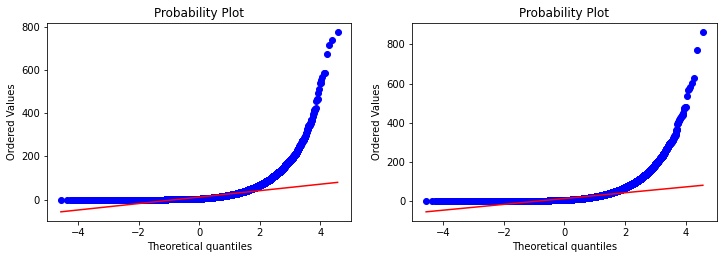

In [61]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
stats.probplot(exp.n_clicks, dist="norm", plot=plt)
plt.subplot(2,2,2)
stats.probplot(control.n_clicks, dist="norm", plot=plt)
plt.show()

No handles with labels found to put in legend.


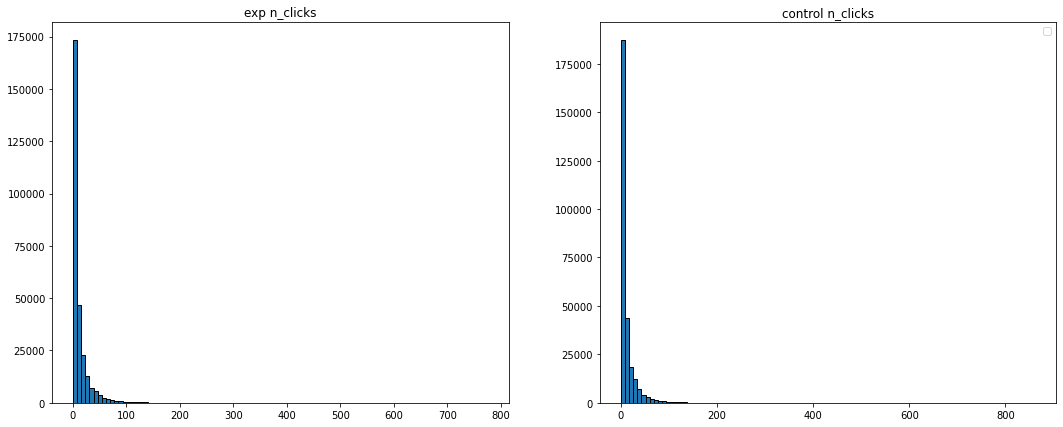

In [62]:
#Age distribution
plt.figure(figsize=(18,7))
plt.subplot(121)
plt.title('exp n_clicks')
plt.hist(exp.n_clicks, edgecolor='k', bins=100)
plt.subplot(122)
plt.title('control n_clicks')
plt.hist(control.n_clicks,edgecolor='k', bins=100)
plt.legend()

Student's t-test has many advantages, and therefore it is often used in AB experiments. Sometimes its use may be unreasonable due to the strong skewness of the data distribution. For simplicity, consider a one-sample t-test.

For the t-test assumptions to actually hold, it is necessary that:

- the mean value in the sample was normally distributed N(μ,σ2n)
- unbiased estimate of variance with scaling factor was chi-squared distributed with n−1 degrees of freedom χ2(n−1)

Both of these assumptions can be tested using bootstrap. For now, we will restrict ourselves to the control group, in which the distribution of clicks will be called data within the framework of this question.

Since we don't know the true distribution of the population, we can apply a bootstrap to understand how the mean and sample variance are distributed.

We get pseudo-samples from the n_boot_samples data.

For each of these samples, we calculate the mean and the sum of the squares of the deviation from the sample mean (control_boot_chi_squared).

For the resulting vector of means from n_boot_samples, plot a q-q plot using scipy.stats.probplot for a normal distribution.

For the resulting vector of sums of squares of the deviation from the sample mean, plot a qq-plot using scipy.stats.probplot for the chi-squared distribution using the command.

Text(0.5, 1.0, 'Probability plot for means')

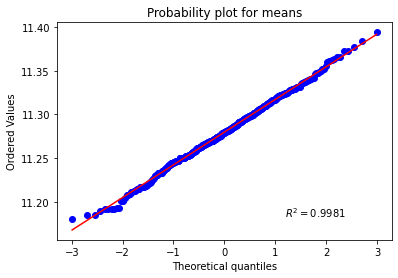

In [69]:
n_boot_samples = 500

control_data = get_bootstrap_samples(control.n_clicks.values, n_boot_samples)

control_means = []
control_vars = []
for i in range(n_boot_samples):
  control_means.append(control_data[i].mean())
  control_vars.append(control_data[i].var())
stats.probplot(control_means, plot=plt, rvalue=True)
plt.title('Probability plot for means')

Text(0.5, 1.0, 'Probability plot for variances')

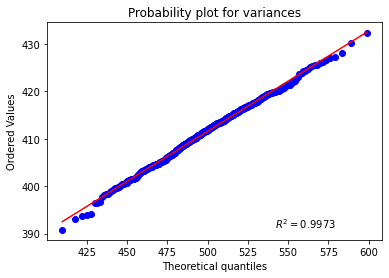

In [71]:
stats.probplot(control_vars, plot=plt, dist='chi2', sparams=(len(control_means)-1), rvalue=True)
plt.title('Probability plot for variances')

One possible analogue of the t-test that can be used is the Mann-Whitney test. On a fairly large class of distributions, it is asymptotically more efficient than the t-test, and it does not require parametric assumptions about the nature of the distribution.


Let's transform the data to the form so that each user corresponds to the total value of his clicks. Using the Mann-Whitney test, we will test the hypothesis about the equality of the means.


In [76]:
usrs_exp = exp.groupby(['userID', 'browser']).sum().loc[:,'n_clicks']
usrs_control = control.groupby(['userID', 'browser']).sum().loc[:, 'n_clicks']

In [77]:
stats.mannwhitneyu(usrs_exp, usrs_control, alternative='two-sided')

MannwhitneyuResult(statistic=41184125116.0, pvalue=6.247235801369629e-75)

p-value < 0.01, so we can say that the differences are negligible at the 0.05 confidence level.

Let's check for which of the browsers the difference between the number of clicks in the control and experimental groups is most pronounced.

To do this, apply for each of the slices (for each of the unique values ​​of the browser column) the Mann-Whitney test between the control and exp groups and make the Holm-Bonferroni correction for multiple validation with α=0.05.


In [91]:
usrs_exp = exp.groupby(['browser', 'userID']).sum().loc[:,'n_clicks']
usrs_control = control.groupby(['browser', 'userID']).sum().loc[:, 'n_clicks']

In [101]:
print('Mann-Whitney rank test without multipletest')
browsers = np.unique(data.browser)
p_val= []
for browser in browsers:
  _, pv = stats.mannwhitneyu(usrs_exp.loc[browser, :], usrs_control.loc[browser, :], alternative='two-sided')
  p_val.append(pv)
  print(f"{browser}, p-value: {pv}")

print('Mann-Whitney rank test with multipletest')
_, p_val_corr, _, _ = multipletests(p_val, alpha = 0.05, method = 'holm')
for i, browser in enumerate(browsers):
    print(f"{browser}, p-value corr: {p_val_corr[i]}")

Mann-Whitney rank test without multipletest
Browser #14, p-value: 0.0
Browser #17, p-value: 0.07480120286021603
Browser #2, p-value: 0.0544877208394482
Browser #20, p-value: 0.9073331277747075
Browser #22, p-value: 0.5148110304420064
Browser #4, p-value: 0.8152123531690997
Mann-Whitney rank test with multipletest
Browser #14, p-value corr: 0.0
Browser #17, p-value corr: 0.29920481144086414
Browser #2, p-value corr: 0.27243860419724103
Browser #20, p-value corr: 1.0
Browser #22, p-value corr: 1.0
Browser #4, p-value corr: 1.0


For each browser in each of the two groups (control and exp), we calculate the proportion of requests in which the user did not click even once. This can be done by dividing the sum of n_nonclk_queries by the sum of n_queries. Multiplying this value by 100, we get the percentage of unclicked requests, which can be more easily interpreted.


In [103]:
nonclk_exp = exp.groupby(['browser']).sum().loc[:,'n_nonclk_queries']
clk_exp = exp.groupby(['browser']).sum().loc[:,'n_queries']
prop_exp = nonclk_exp / clk_exp

nonclk_control = control.groupby(['browser']).sum().loc[:,'n_nonclk_queries']
clk_control = control.groupby(['browser']).sum().loc[:,'n_queries']
prop_control = nonclk_control  / clk_control

In [108]:
print('Control/exp')
for browser in browsers:
    print(browser, prop_control.loc[prop_control.index == browser].values, prop_exp.loc[prop_exp.index == browser].values)

Control/exp
Browser #14 [0.57590411] [0.43755617]
Browser #17 [0.36299367] [0.36937413]
Browser #2 [0.45962747] [0.44982747]
Browser #20 [0.40540485] [0.38977376]
Browser #22 [0.40593977] [0.39853947]
Browser #4 [0.4697093] [0.45142942]
